In [1]:
import pandas as pd
import numpy as np
from catboost import datasets, CatBoostClassifier
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import accuracy_score

In [7]:
adult_train, adult_valid = datasets.adult()

In [40]:
X = adult_train.drop("income", axis=1)
y = adult_train["income"]

In [42]:
y.replace({">50K": 1, "<=50K": 0}, inplace=True)

In [43]:
def preprocess(df):
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            dummies = pd.get_dummies(content, prefix=label)
            df = pd.concat([df, dummies], axis=1)
            df.drop(label, axis=1, inplace=True)
            
    return df

In [51]:
X = preprocess(X)

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [57]:
model = CatBoostClassifier()

In [58]:
model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [59]:
y_preds = model.predict(X_valid)

In [60]:
accuracy_score(y_valid, y_preds)

0.8824854130412529

In [61]:
def objective(trial):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4)

    param = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 4, 10)
    }
    
    model = CatBoostClassifier(**param, verbose=False, early_stopping_rounds=50)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

In [62]:
study = optuna.create_study(direction="maximize")

[I 2024-04-24 09:59:12,922] A new study created in memory with name: no-name-8d2b8e63-ce85-41fe-9a2a-03b9e3c9cc88


In [65]:
study.optimize(func=objective, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-04-24 12:10:09,004] Trial 100 finished with value: 0.8704030710172744 and parameters: {'iterations': 625, 'learning_rate': 0.052280963731317576, 'depth': 5, 'l2_leaf_reg': 7}. Best is trial 80 with value: 0.8775431861804223.
[I 2024-04-24 12:10:12,440] Trial 101 finished with value: 0.870172744721689 and parameters: {'iterations': 983, 'learning_rate': 0.0716549844826504, 'depth': 7, 'l2_leaf_reg': 6}. Best is trial 80 with value: 0.8775431861804223.
[I 2024-04-24 12:10:15,143] Trial 102 finished with value: 0.870172744721689 and parameters: {'iterations': 932, 'learning_rate': 0.0767929621787917, 'depth': 7, 'l2_leaf_reg': 6}. Best is trial 80 with value: 0.8775431861804223.
[I 2024-04-24 12:10:18,548] Trial 103 finished with value: 0.8717850287907869 and parameters: {'iterations': 832, 'learning_rate': 0.07807086639693767, 'depth': 8, 'l2_leaf_reg': 6}. Best is trial 80 with value: 0.8775431861804223.
[I 2024-04-24 12:10:23,500] Trial 104 finished with value: 0.87332053742802

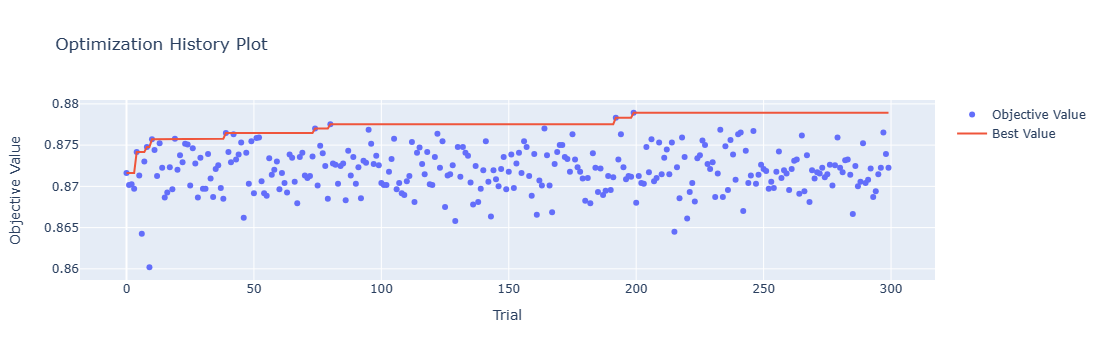

In [66]:
optuna.visualization.plot_optimization_history(study)